In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multitest import multipletests
from statsmodels.robust.robust_linear_model import RLM

In [2]:
sentiments = pd.read_csv("combined_sentiments.csv")
emotions = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'none']
epsilon = 1e-6
def label_p(p):
    if p <= 0.001:
        return "p <= .001"
    elif p <= 0.01:
        return "p <= .01"
    elif p <= 0.05:
        return "p <= .05"
    elif p > 0.05 and p < 0.1:
        return "p > .05"
    else:
        return "p > .1"
for e in emotions:
    sentiments[f"{e}_p_logit"] = np.log((sentiments[f"{e}_p"] + epsilon) / (1 - sentiments[f"{e}_p"] + epsilon))
    sentiments[f"{e}_a_logit"] = np.log((sentiments[f"{e}_a"] + epsilon) / (1 - sentiments[f"{e}_a"] + epsilon))


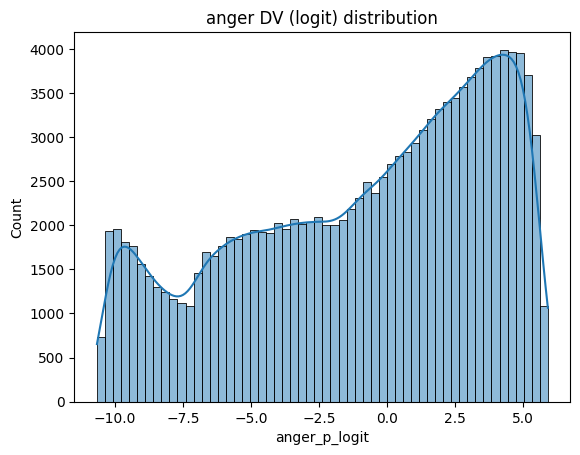

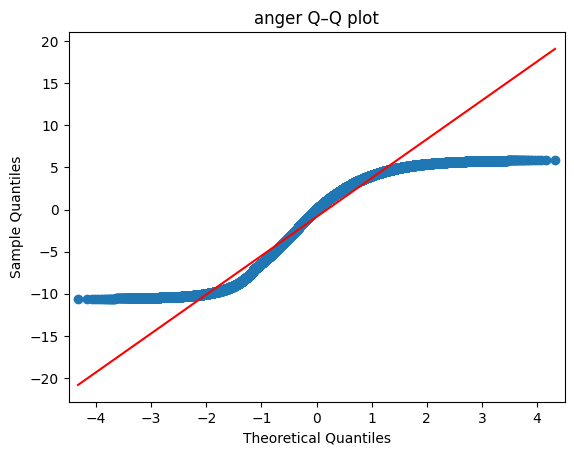

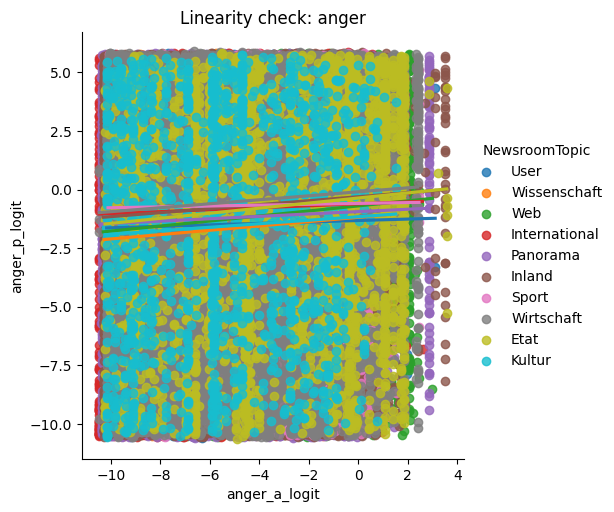

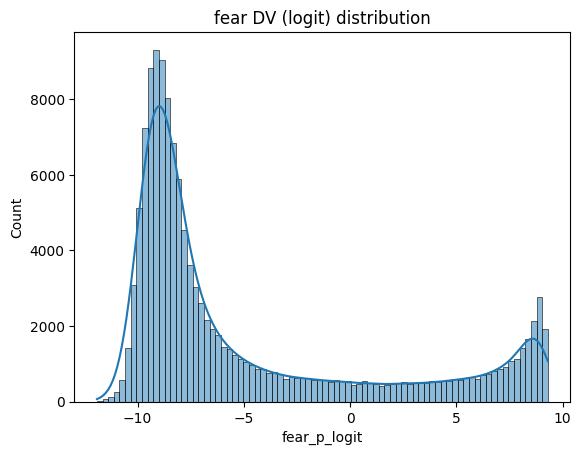

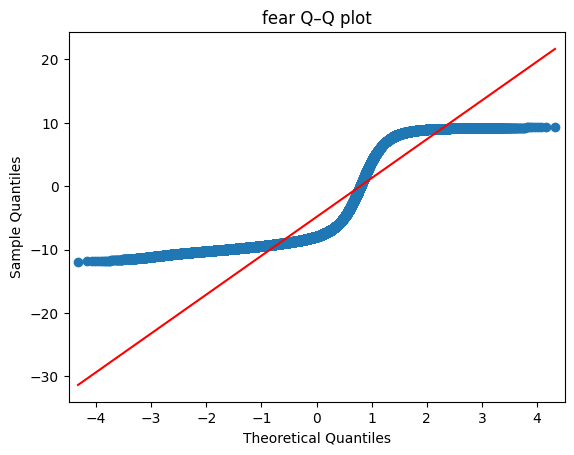

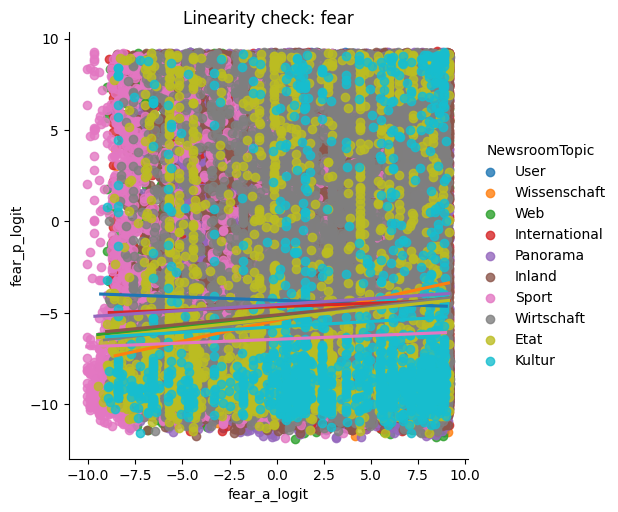

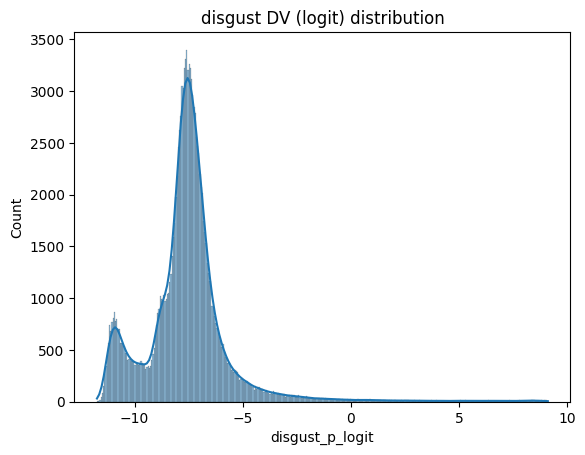

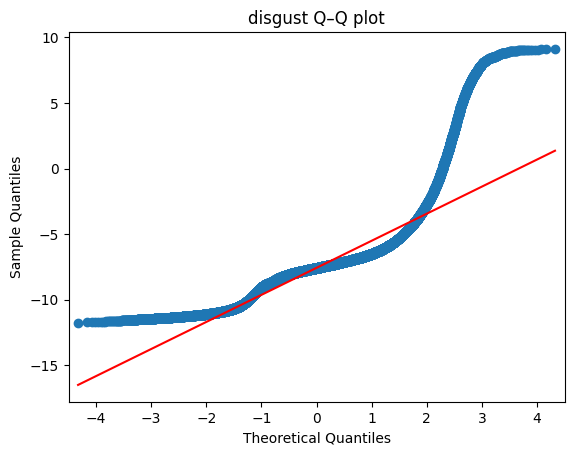

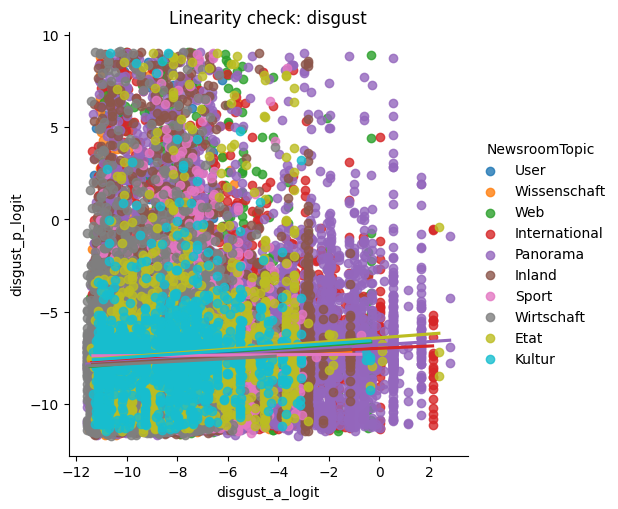

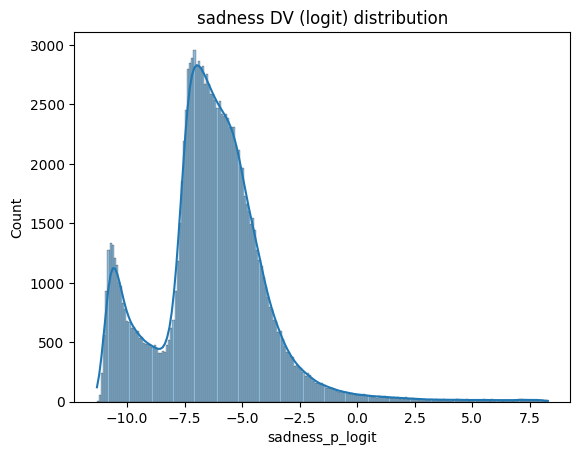

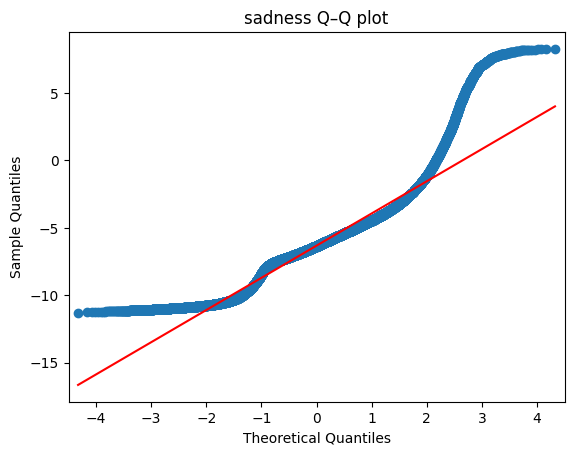

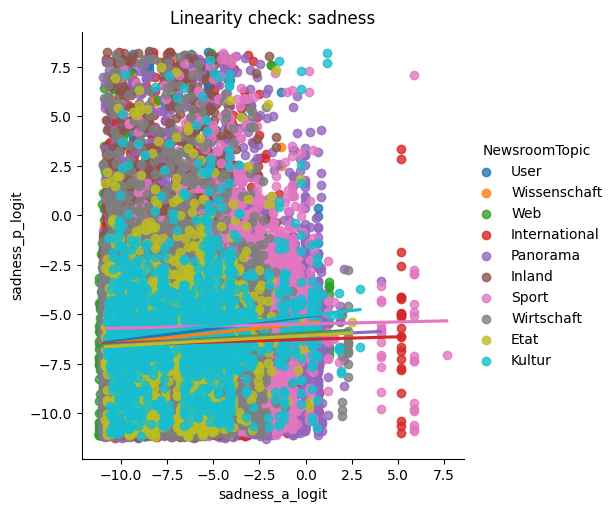

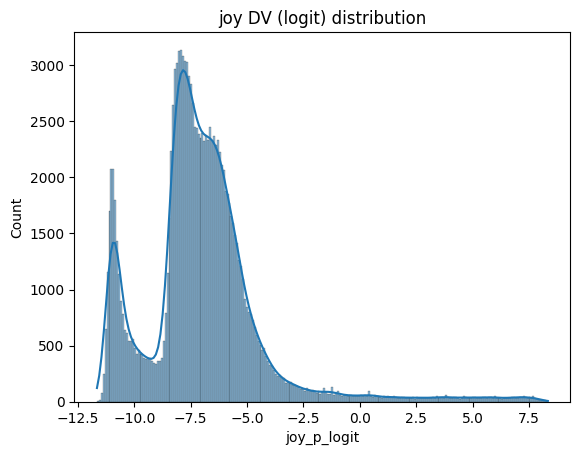

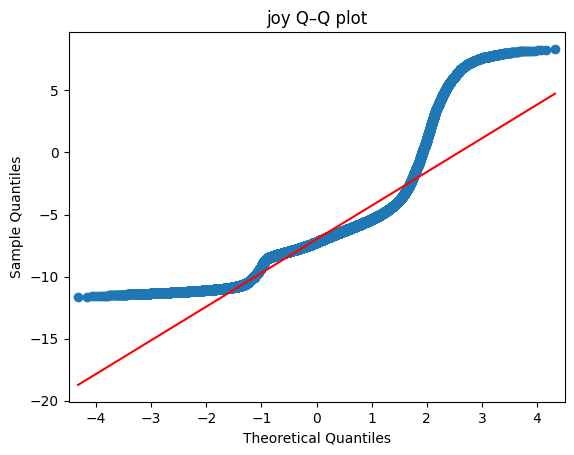

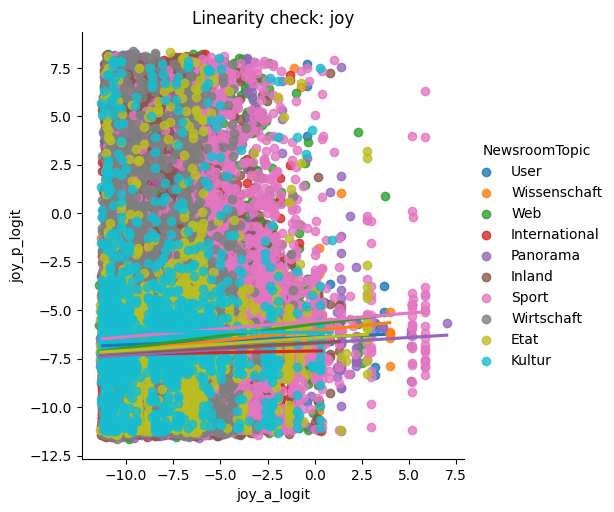

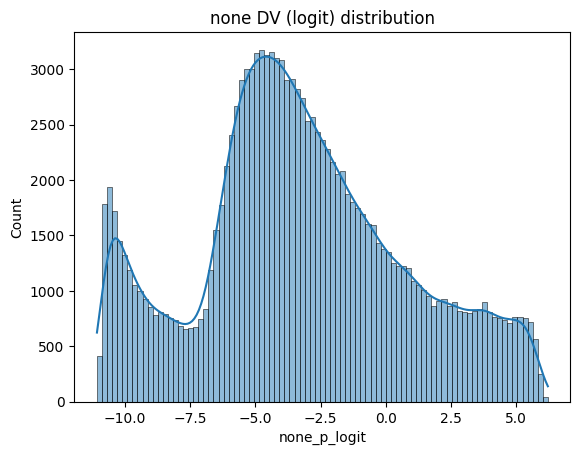

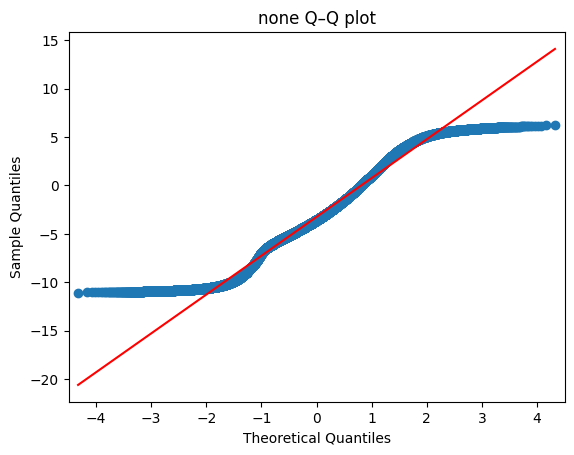

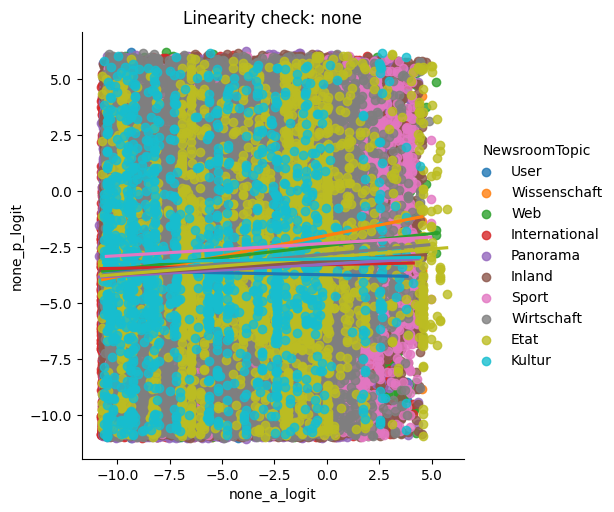

In [ ]:
for e in emotions:
    sns.histplot(sentiments[f"{e}_p_logit"], kde=True)
    plt.title(f"{e} DV (logit) distribution")
    plt.show()

    sm.qqplot(sentiments[f"{e}_p_logit"], line='s')
    plt.title(f"{e} Q–Q plot")
    plt.show()

    sns.lmplot(
        x=f"{e}_a_logit",
        y=f"{e}_p_logit",
        hue="NewsroomTopic",
        data=sentiments,
        ci=None
    )
    plt.title(f"Linearity check: {e}")
    plt.show()

In [4]:
X = sentiments[[f"{e}_a_logit" for e in emotions]].dropna()
vif = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

          Variable        VIF
0    anger_a_logit  15.880998
1     fear_a_logit   9.810006
2  disgust_a_logit  42.947171
3  sadness_a_logit  36.731151
4      joy_a_logit  50.773406
5     none_a_logit  28.119268


In [ ]:
for e in emotions:
    formula = f"{e}_p_logit ~ C(NewsroomTopic) * {e}_a_logit"
    model = ols(formula, data=sentiments).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    p_interaction = anova.loc[f"C(NewsroomTopic):{e}_a_logit", "PR(>F)"]
    p_label = label_p(p_interaction)
    print(f"{e} interaction p-value: {p_interaction:.4f} ({p_label})")

anger interaction p-value: 0.0000 (p <= .001)
fear interaction p-value: 0.0000 (p <= .001)
disgust interaction p-value: 0.0000 (p <= .001)
sadness interaction p-value: 0.0000 (p <= .001)
joy interaction p-value: 0.0000 (p <= .001)
none interaction p-value: 0.0000 (p <= .001)


In [6]:
for e in emotions:
    formula = f"{e}_p_logit ~ C(NewsroomTopic) + " + " + ".join([f"{x}_a_logit" for x in emotions])
    model = ols(formula, data=sentiments).fit()
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    p_bp = bp_test[1]
    
    print(f"{e} BP p-value: {p_bp}")
    
    if p_bp < 0.05:
        print(f"Heteroscedasticity detected for {e}. Using robust regression.")
        rlm_model = RLM.from_formula(formula, data=sentiments).fit()
        print(rlm_model.summary())

anger BP p-value: 9.920685305166876e-162
Heteroscedasticity detected for anger. Using robust regression.
                    Robust linear Model Regression Results                    
Dep. Variable:          anger_p_logit   No. Observations:               131548
Model:                            RLM   Df Residuals:                   131532
Method:                          IRLS   Df Model:                           15
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 10 Jan 2026                                         
Time:                        17:43:04                                         
No. Iterations:                    20                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
---

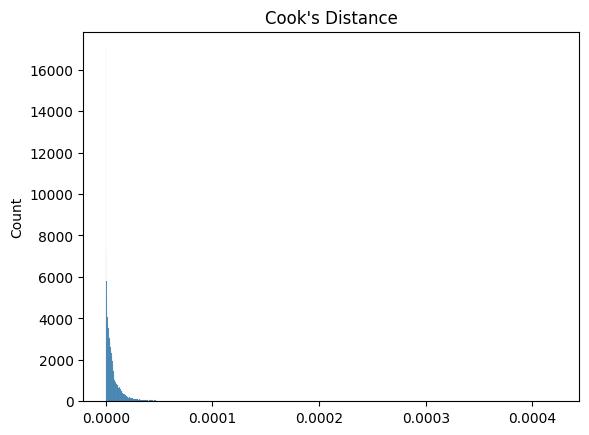

In [7]:
model = ols(
    "anger_p_logit ~ C(NewsroomTopic) + " + " + ".join([f"{x}_a_logit" for x in emotions]),
    data=sentiments
).fit()

influence = model.get_influence()
c, _ = influence.cooks_distance
sns.histplot(c)
plt.title("Cook's Distance")
plt.show()

In [22]:
dvs = [f"{e}_p_logit" for e in emotions]
iv_formula = "C(NewsroomTopic) + " + " + ".join([f"{e}_a_logit" for e in emotions])
formula = f"{' + '.join(dvs)} ~ {iv_formula}"

manova = MANOVA.from_formula(formula, data=sentiments)
mv_test_res = manova.mv_test().results

cond_dict = {}
for g in sentiments['NewsroomTopic'].unique():
    cov = sentiments.loc[sentiments['NewsroomTopic'] == g, dvs].cov()
    cond_number = np.linalg.cond(cov)
    cond_dict[g] = cond_number

avg_cond_number = np.mean(list(cond_dict.values()))

manova_rows = []

for effect, stats_dict in mv_test_res.items():
    stat_df = stats_dict['stat']
    for test_name in stat_df.index:
        F = stat_df.loc[test_name, "F Value"]
        num_df = stat_df.loc[test_name, "Num DF"]
        den_df = stat_df.loc[test_name, "Den DF"]
        p_val = stat_df.loc[test_name, "Pr > F"]
        wilks_lambda = stat_df.loc[test_name, "Value"]

        row = {
            "Effect": effect,
            "Test": test_name,
            "Wilks_Lambda": wilks_lambda,
            "F": F,
            "Num DF": num_df,
            "Den DF": den_df,
            "Pr > F": p_val,
            "p_bonf": None,
            "p_label": None,
            "Avg_Cond_Number": avg_cond_number
        }
        manova_rows.append(row)

manova_df = pd.DataFrame(manova_rows)
manova_df['p_bonf'] = multipletests(manova_df['Pr > F'], method='bonferroni')[1]
manova_df['p_label'] = manova_df['p_bonf'].apply(label_p)
manova_df = manova_df[manova_df['Test'] == "Pillai's trace"].reset_index(drop=True)
manova_df


,Effect,Test,Wilks_Lambda,F,Num DF,Den DF,Pr > F,p_bonf,p_label,Avg_Cond_Number
0,Intercept,Pillai's trace,0.359082,12281.581562,6.0,131527.0,0.000000e+00,0.000000e+00,p <= .001,29.108912
1,C(NewsroomTopic),Pillai's trace,0.020876,51.026521,54.0,789192.0,0.000000e+00,0.000000e+00,p <= .001,29.108912
2,anger_a_logit,Pillai's trace,0.004377,96.379770,6.0,131527.0,2.108785e-121,6.748112e-120,p <= .001,29.108912
3,fear_a_logit,Pillai's trace,0.000415,9.105936,6.0,131527.0,5.517963e-10,1.765748e-08,p <= .001,29.108912
4,disgust_a_logit,Pillai's trace,0.010874,240.988813,6.0,131527.0,1.386472e-307,4.436710e-306,p <= .001,29.108912
5,sadness_a_logit,Pillai's trace,0.004869,107.263390,6.0,131527.0,2.003093e-135,6.409898e-134,p <= .001,29.108912
6,joy_a_logit,Pillai's trace,0.000756,16.595444,6.0,131527.0,3.135054e-19,1.003217e-17,p <= .001,29.108912
7,none_a_logit,Pillai's trace,0.000598,13.106170,6.0,131527.0,6.902987e-15,2.208956e-13,p <= .001,29.108912


In [ ]:
ancova_results = []

for dv in emotions:
    formula = f"{dv}_p_logit ~ C(NewsroomTopic) + " + " + ".join([f"{e}_a_logit" for e in emotions])
    
    model = ols(formula, data=sentiments).fit(cov_type='HC3')
    
    anova_df = anova_lm(model, typ=2).reset_index()
    
    ss_error = anova_df.loc[anova_df['index'] == 'Residual', 'sum_sq'].values[0]
    anova_df['eta_p2'] = anova_df.apply(
        lambda row: row['sum_sq'] / (row['sum_sq'] + ss_error) if row['index'] != 'Residual' else np.nan,
        axis=1
    )
    
    anova_df['eta_ci'] = anova_df.apply(
        lambda row: (
            row['F'] / (row['F'] + ss_error / row['df'] * f.ppf(1-0.05/2, row['df'], int(ss_error))),
            row['F'] / (row['F'] + ss_error / row['df'] * f.ppf(0.05/2, row['df'], int(ss_error)))
        ) if row['index'] != 'Residual' else (np.nan, np.nan),
        axis=1
    )
    
    corrected_pvals = multipletests(anova_df['PR(>F)'], method='bonferroni')[1]
    anova_df['p_bonf'] = corrected_pvals
    anova_df['p_label'] = anova_df['p_bonf'].apply(label_p)
    
    anova_df['emotion'] = dv
    
    ancova_results.append(anova_df)

ancova_results = pd.concat(ancova_results, ignore_index=True)
ancova_results

,index,sum_sq,df,F,PR(>F),eta_p2,eta_ci,p_bonf,p_label,emotion
0,C(NewsroomTopic),1.151511e+04,9.0,60.661664,1.421946e-111,0.004134,"(9.309824716875977e-05, 0.0006554593398539727)",1.137557e-110,p <= .001,anger
1,anger_a_logit,4.222230e+03,1.0,200.184532,2.055597e-45,0.001520,"(1.436287101292075e-05, 0.06844682089421063)",1.644478e-44,p <= .001,anger
2,fear_a_logit,4.882119e+02,1.0,23.147125,1.502333e-06,0.000176,"(1.6607845995455347e-06, 0.008424381023609706)",1.201867e-05,p <= .001,anger
3,disgust_a_logit,6.069913e+01,1.0,2.877870,8.980712e-02,0.000022,"(2.0648477420703369e-07, 0.0010551829180229953)",7.184569e-01,p > .1,anger
4,sadness_a_logit,2.727010e+03,1.0,129.293117,6.042473e-30,0.000982,"(9.276589910207287e-06, 0.04530589947829944)",4.833979e-29,p <= .001,anger
5,joy_a_logit,6.791879e+01,1.0,3.220168,7.273844e-02,0.000024,"(2.3104440983596814e-07, 0.0011805399594025708)",5.819075e-01,p > .1,anger
6,none_a_logit,1.904874e+02,1.0,9.031398,2.654315e-03,0.000069,"(6.479950076399066e-07, 0.003303945020950701)",2.123452e-02,p <= .05,anger
7,Residual,2.774232e+06,131532.0,NaN,NaN,NaN,"(nan, nan)",NaN,p > .1,anger
8,C(NewsroomTopic),2.627728e+04,9.0,78.655215,3.516796e-146,0.005353,"(6.859092724962565e-05, 0.000482986149443103)",2.813437e-145,p <= .001,fear
9,anger_a_logit,4.997549e+02,1.0,13.463148,2.433912e-04,0.000102,"(5.488636704697582e-07, 0.002799915932447006)",1.947129e-03,p <= .01,fear


In [ ]:
interaction_results = []

for dv in emotions:
    interaction_terms = " + ".join([f"C(NewsroomTopic):{e}_a_logit" for e in emotions])
    formula = f"{dv}_p_logit ~ C(NewsroomTopic) + " + " + ".join([f"{e}_a_logit" for e in emotions]) + " + " + interaction_terms
    
    model = ols(formula, data=sentiments).fit(cov_type='HC3')
    
    anova_df = anova_lm(model, typ=3).reset_index()
    
    interaction_df = anova_df[anova_df['index'].str.contains(":")].copy()
    
    ss_error = anova_df.loc[anova_df['index'] == 'Residual', 'sum_sq'].values[0]
    interaction_df['eta_p2'] = interaction_df['sum_sq'] / (interaction_df['sum_sq'] + ss_error)
    
    interaction_df['eta_ci'] = interaction_df.apply(
        lambda row: (
            row['F'] / (row['F'] + ss_error / row['df'] * f.ppf(1-0.05/2, row['df'], int(ss_error))),
            row['F'] / (row['F'] + ss_error / row['df'] * f.ppf(0.05/2, row['df'], int(ss_error)))
        ),
        axis=1
    )
    
    corrected_pvals = multipletests(interaction_df['PR(>F)'], method='bonferroni')[1]
    interaction_df['p_bonf'] = corrected_pvals
    interaction_df['p_label'] = interaction_df['p_bonf'].apply(label_p)
    
    interaction_df['emotion'] = dv
    
    interaction_results.append(interaction_df)

interaction_results = pd.concat(interaction_results, ignore_index=True)
interaction_results


,index,sum_sq,df,F,PR(>F),eta_p2,eta_ci,p_bonf,p_label,emotion
0,C(NewsroomTopic):anger_a_logit,623.155035,9.0,3.286082,5.186155e-04,0.000225,"(5.0507777616342796e-06, 3.557898688085889e-05)",3.111693e-03,p <= .01,anger
1,C(NewsroomTopic):fear_a_logit,425.237372,9.0,2.242403,1.682989e-02,0.000153,"(3.44662690226837e-06, 2.4279168106021944e-05)",1.009793e-01,p > .1,anger
2,C(NewsroomTopic):disgust_a_logit,356.302076,9.0,1.878887,5.015470e-02,0.000129,"(2.887895294123818e-06, 2.0343348467971382e-05)",3.009282e-01,p > .1,anger
3,C(NewsroomTopic):sadness_a_logit,1051.710364,9.0,5.545982,1.122127e-07,0.000379,"(8.52426213431339e-06, 6.004584990849382e-05)",6.732763e-07,p <= .001,anger
4,C(NewsroomTopic):joy_a_logit,1048.671655,9.0,5.529958,1.194362e-07,0.000378,"(8.499633171772696e-06, 5.9872369671644016e-05)",7.166173e-07,p <= .001,anger
5,C(NewsroomTopic):none_a_logit,452.513285,9.0,2.386237,1.070058e-02,0.000163,"(3.66770237257343e-06, 2.583646156074387e-05)",6.420350e-02,p > .05,anger
6,C(NewsroomTopic):anger_a_logit,2396.886678,9.0,7.195059,1.619905e-10,0.000492,"(6.295332503800659e-06, 4.434556297901766e-05)",9.719432e-10,p <= .001,fear
7,C(NewsroomTopic):fear_a_logit,2261.543090,9.0,6.788780,8.274455e-10,0.000464,"(5.939859784840191e-06, 4.184163298158621e-05)",4.964673e-09,p <= .001,fear
8,C(NewsroomTopic):disgust_a_logit,3011.290710,9.0,9.039399,8.785637e-14,0.000618,"(7.909028771940619e-06, 5.571221416205227e-05)",5.271382e-13,p <= .001,fear
9,C(NewsroomTopic):sadness_a_logit,1904.442160,9.0,5.716822,5.760680e-08,0.000391,"(5.001952012074667e-06, 3.5235011317050606e-05)",3.456408e-07,p <= .001,fear
